In [2]:
import numpy as np
from numpy.linalg import inv
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

class MetricGraph:
    def __init__(self, edges, vertex_count):
        self.edges = [(min(edge[0], edge[1]), max(edge[0], edge[1]), edge[2]) for edge in edges]
        self.graph = [{"src": s, "dst": d, "weight": w} for s, d, w in edges]
        self.weights = dict([((s, d), w) for s, d, w in edges])
        self.vertex_count = vertex_count
        self.edge_count = len(self.edges)
        self.shortest_paths = self.calculate_shortest_paths()
        self.sum_len = sum([w for s, d, w in edges])
    
    def bellman_ford(self, src: int) -> list[float]:
        distance = [float("inf")] * self.vertex_count
        distance[src] = 0.0

        for _ in range(self.vertex_count - 1):
            for j in range(self.edge_count):
                u, v, w = (self.graph[j][k] for k in ["src", "dst", "weight"])
                if distance[u] != float("inf") and distance[u] + w < distance[v]:
                    distance[v] = distance[u] + w
        return distance
    
    def calculate_shortest_paths(self) -> list[list[float]]:
        return [self.bellman_ford(src) for src in range(self.vertex_count)]
    
    def point_params(self, p):
        return min(p[0], p[1]), max(p[0], p[1]), p[2]
    
    def dist(self, p1: tuple[int, int, float], p2: tuple[int, int, float]) -> int:
        v1, v2, vx = self.point_params(p1)
        u1, u2, ux = self.point_params(p2)
        vl, ul = self.weights[(v1, v2)], self.weights[(u1, u2)]
        vy, uy = vl - vx, ul - ux # dist from v2 and u2
        
        possible_paths = []
        if v1 == u1 and v2 == u2: # same edge
            possible_paths.append(abs(vx - ux))
        possible_paths.append(vx + self.shortest_paths[v1][u1] + ux)
        possible_paths.append(vx + self.shortest_paths[v1][u2] + uy)
        possible_paths.append(vy + self.shortest_paths[v2][u1] + ux)
        possible_paths.append(vy + self.shortest_paths[v2][u2] + uy)
        return min(possible_paths)
    
    def generate_points(self, num_points: int) -> list[tuple[int, int, float]]:
        part_len = self.sum_len / num_points
        points = []
        for v, u, w in self.edges:
            points += [(v, u, part_len * i) for i in range(1, int(w / part_len))]
        return points
        
    def calculate_magnitude(self, t: float, num_points: int) -> float:
        points = self.generate_points(num_points)
        distance = np.array([[self.dist(p1, p2) for p1 in points] for p2 in points])
        exp_dist = np.exp(-distance * t)
        exp_dist_inv = np.linalg.inv(exp_dist)
        return np.sum(exp_dist_inv)
    
    def approximate_magnitude_function(self, t_vec, range_params):
        num_points_vec = np.linspace(range_params[0], range_params[1], range_params[2])
        magnitude_measures = [[self.calculate_magnitude(t, num_points) for num_points in num_points_vec] for t in t_vec]
        return magnitude_measures
    
    def plot_magnitude_function(self, t_vec, magnitude_measures, axes):
        magnitude_res = [elem[-1] for elem in magnitude_measures]
        sns.lineplot(x=t_vec, y=magnitude_res, label='experiment', color='darkred', ax=axes)
    
    def absolute_error(self, t_vec, magnitude_measures, real_values, axes):
        measure_error = [abs(elem[-1] - elem[-2]) for elem in magnitude_measures]
        magnitude_error = [abs(elem[-1] - real_values[i]) for i, elem in enumerate(magnitude_measures)]
        sns.lineplot(x=t_vec, y=measure_error, label='convergence delta', color='darkred', ax=axes)
        sns.lineplot(x=t_vec, y=magnitude_error, label='magnitude error', color='salmon', ax=axes)
        return magnitude_error
        
        
    def approx_error(self, t_vec, magnitude_measures, real_values, axes):
        measure_error = [abs(elem[-1] - elem[-2])/elem[-1] for elem in magnitude_measures]
        magnitude_error = [abs(elem[-1] - real_values[i])/elem[-1] for i, elem in enumerate(magnitude_measures)]
        sns.lineplot(x=t_vec, y=measure_error, label='approximate convergence delta', color='darkred', ax=axes)
        sns.lineplot(x=t_vec, y=magnitude_error, label='approximate magnitude error', color='salmon', ax=axes)
        return magnitude_error
    
    def plot_all(self, t_vec, magnitude_measures, real_func, real_func_name, axes):
        ax1, ax2 = axes
        t_len = [self.sum_len * t for t in t_vec]
        real_values = [real_func(t) for t in t_len]
        self.plot_magnitude_function(t_len, magnitude_measures, ax1)
        sns.lineplot(x=t_len, y=real_values, color='salmon', label=real_func_name, ax=ax1)
        print('Absolute delta:', self.absolute_error(t_len, magnitude_measures, real_values, ax2))

In [3]:
t_vec = np.linspace(10, 300, 8)

ОТРЕЗОК

Absolute delta: [0.005020822862244145, 0.028546500773565242, 0.06309697105758971, 0.11754340530998775, 0.20073991889455556, 0.32151600230665167, 0.4886689972960312, 0.7109566313766891]


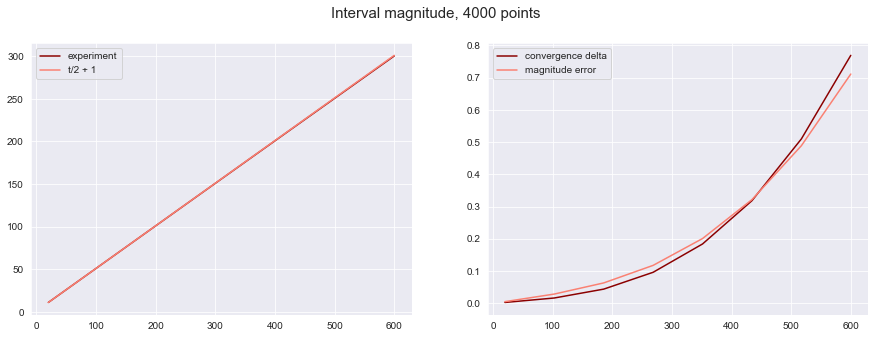

In [9]:
interval = MetricGraph(edges=[(0, 1, 2)], vertex_count=2)
magnitude_measures_interval = interval.approximate_magnitude_function(t_vec, [10, 4000, 4])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Interval magnitude, 4000 points', fontsize=15)
interval.plot_all(t_vec, magnitude_measures_interval, lambda t: t/2 + 1, 't/2 + 1', (ax1, ax2))

ДЕРЕВЬЯ

Absolute delta: [0.03296251545467044, 0.24097637364849334, 0.7427639877699335, 1.7754327295555186, 3.5720755979201613, 6.360022149618544, 10.359179476962936, 15.780488887476281]


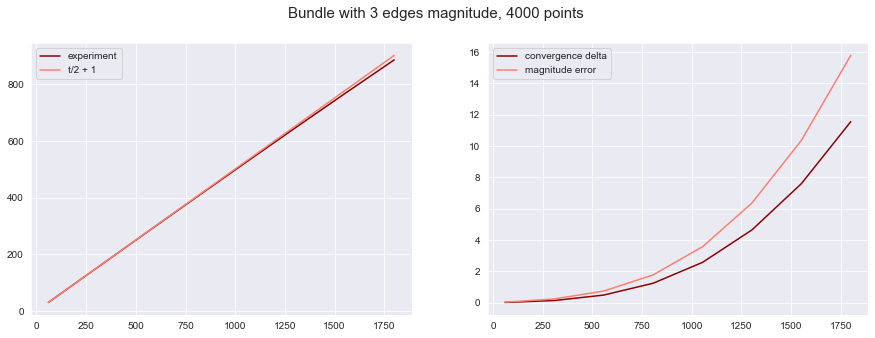

In [10]:
bundle3 = MetricGraph(edges=[(0, 1, 2), (0, 2, 3), (0, 3, 1)], vertex_count=4)
magnitude_measures_bundle3 = bundle3.approximate_magnitude_function(t_vec, [10, 4000, 5])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Bundle with 3 edges magnitude, 4000 points', fontsize=15)
bundle3.plot_all(t_vec, magnitude_measures_bundle3, lambda t: t/2 + 1, 't/2 + 1', (ax1, ax2))

Absolute delta: [0.06191198067017467, 0.43013522380584845, 1.2612097383261585, 2.9294216887319067, 5.800520505947588, 10.228052153267413, 16.54994566587095, 25.085420120689605]


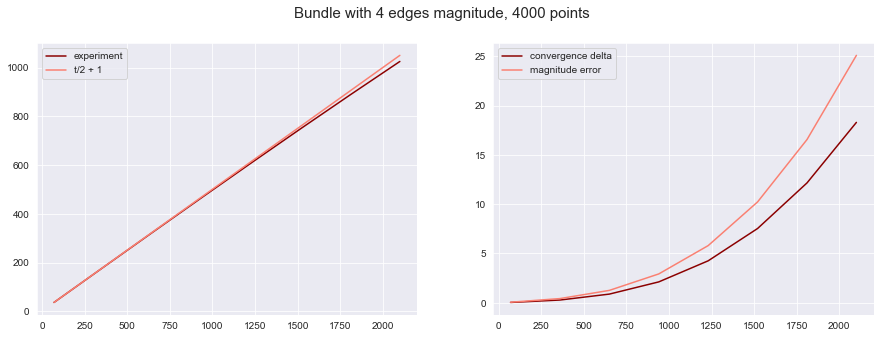

In [11]:
bundle4 = MetricGraph(edges=[(0, 1, 2), (0, 2, 3), (0, 3, 1), (0, 4, 1)], vertex_count=5)
magnitude_measures_bundle4 = bundle4.approximate_magnitude_function(t_vec, [10, 4000, 5])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Bundle with 4 edges magnitude, 4000 points', fontsize=15)
bundle4.plot_all(t_vec, magnitude_measures_bundle4, lambda t: t/2 + 1, 't/2 + 1', (ax1, ax2))

Absolute delta: [0.04638185272110107, 0.30570494993943953, 0.8530328123746358, 1.9272324079346959, 3.7633556066949723, 6.5907557375254555, 10.63128723641853, 16.097631954141434]


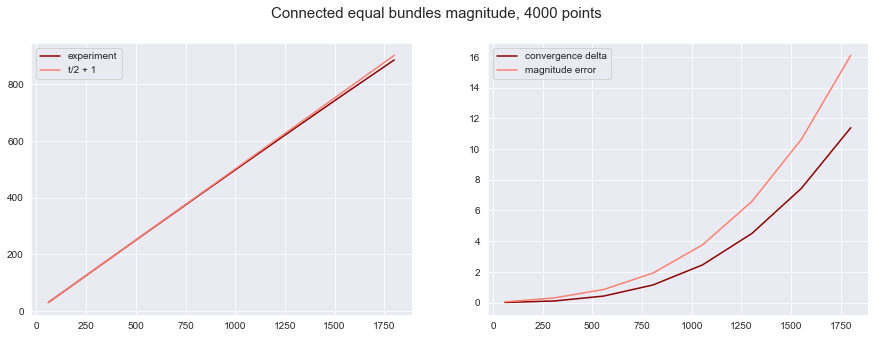

In [12]:
comb_bundle = MetricGraph(edges=[(0, 2, 1), (1, 2, 1), (3, 4, 1), (3, 5, 1), (2, 3, 2)], vertex_count=6)
magnitude_measures_comb_bundle = comb_bundle.approximate_magnitude_function(t_vec, [10, 4000, 5])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Connected equal bundles magnitude, 4000 points', fontsize=15)
comb_bundle.plot_all(t_vec, magnitude_measures_comb_bundle, lambda t: t/2 + 1, 't/2 + 1', (ax1, ax2))

Absolute delta: [0.06889053284882607, 0.4599175361313428, 1.3055770065390675, 2.9827592000692675, 5.860198280313853, 10.294577881706118, 16.62686682653373, 25.178987338760862]


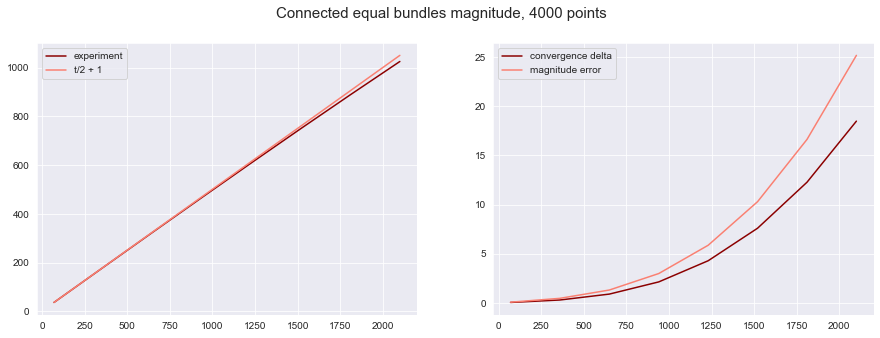

In [13]:
comb_bundle1 = MetricGraph(edges=[(0, 2, 1), (1, 2, 1), (3, 4, 1), (3, 5, 1), (3, 6, 1), (2, 3, 2)], vertex_count=7)
magnitude_measures_comb_bundle1 = comb_bundle1.approximate_magnitude_function(t_vec, [10, 4000, 5])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Connected equal bundles magnitude, 4000 points', fontsize=15)
comb_bundle1.plot_all(t_vec, magnitude_measures_comb_bundle1, lambda t: t/2 + 1, 't/2 + 1', (ax1, ax2))

ЦИКЛ

Absolute delta: [1.0001447092781106, 1.0227664421407212, 1.1339256154065538, 1.404661394278662, 1.9054352164295665, 2.705911559409742, 3.874722123671063, 5.4792378711059655]


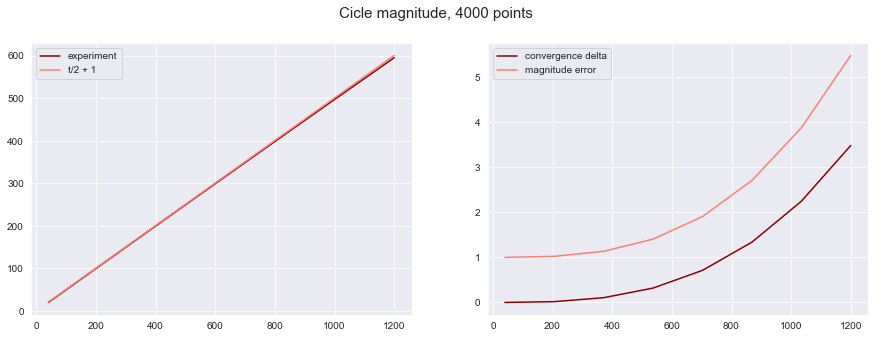

In [17]:
cicle = MetricGraph(edges=[(0, 1, 1), (0, 2, 2), (1, 2, 1)], vertex_count=3)
magnitude_measures_cicle = cicle.approximate_magnitude_function(t_vec, [10, 4000, 5])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Cicle magnitude, 4000 points', fontsize=15)
cicle.plot_all(t_vec, magnitude_measures_cicle, lambda t: t/2 + 1, 't/2 + 1', (ax1, ax2))

Absolute delta: [0.00014470927811061074, 0.02276644214072121, 0.1339256154065538, 0.4046613942786621, 0.9054352164295665, 1.705911559409742, 2.874722123671063, 4.4792378711059655]


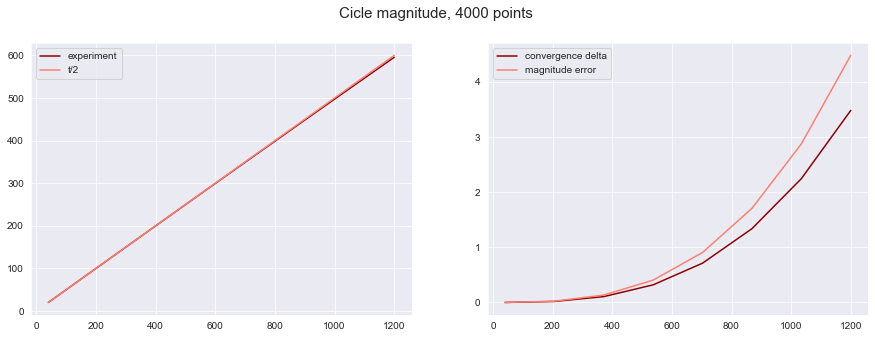

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Cicle magnitude, 4000 points', fontsize=15)
cicle.plot_all(t_vec, magnitude_measures_cicle, lambda t: t/2, 't/2', (ax1, ax2))

2 ЦИКЛА СКЛЕЕННЫЕ ПО ВЕРШИНЕ

Absolute delta: [2.0112518366140932, 2.168594241322694, 2.7910455772413343, 4.259036637251768, 6.94395333530872, 11.204224496692177, 17.381662637484624, 25.7982190753969]


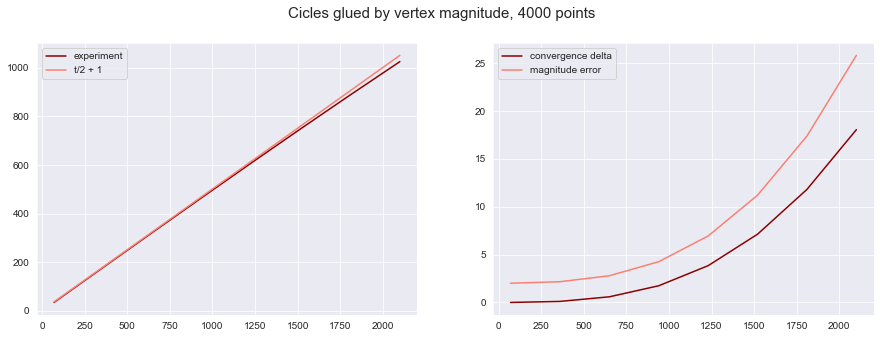

In [19]:
eight_cicle = MetricGraph(edges=[(0, 1, 1), (0, 2, 2), (1, 2, 1), (2, 3, 1), (3, 4, 1), (2, 4, 1)], vertex_count=5)
magnitude_measures_eight_cicle = eight_cicle.approximate_magnitude_function(t_vec, [10, 4000, 5])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Cicles glued by vertex magnitude, 4000 points', fontsize=15)
eight_cicle.plot_all(t_vec, magnitude_measures_eight_cicle, lambda t: t/2 + 1, 't/2 + 1', (ax1, ax2))

Absolute delta: [2.0112518366140932, 2.168594241322694, 2.7910455772413343, 4.259036637251768, 6.94395333530872, 11.204224496692177, 17.381662637484624, 25.7982190753969]


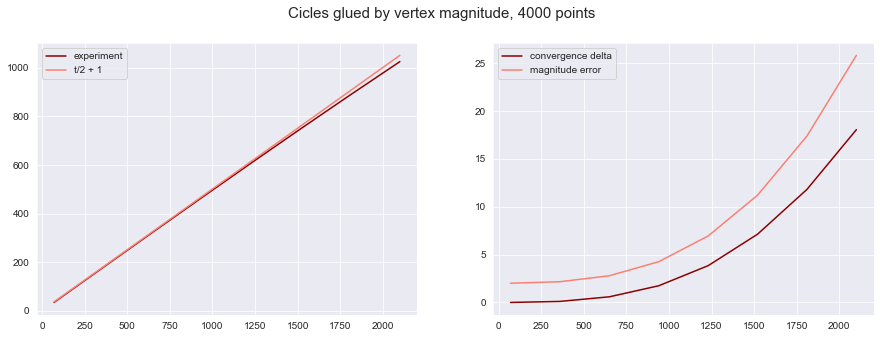

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Cicles glued by vertex magnitude, 4000 points', fontsize=15)
eight_cicle.plot_all(t_vec, magnitude_measures_eight_cicle, lambda t: t/2 + 1, 't/2 + 1', (ax1, ax2))

ЦИКЛ С ПРИКРЕПЛЕННЫМИ ДЕРЕВЬЯМИ

2 ЦИКЛА СКЛЕЕННЫЕ ПО РЕБРУ

Absolute delta: [2.009975118805805, 2.2901337616652313, 3.5651798909613603, 6.6360357818171, 12.270936804846883, 21.192292837619675, 34.06572843468007, 51.49151252195179]


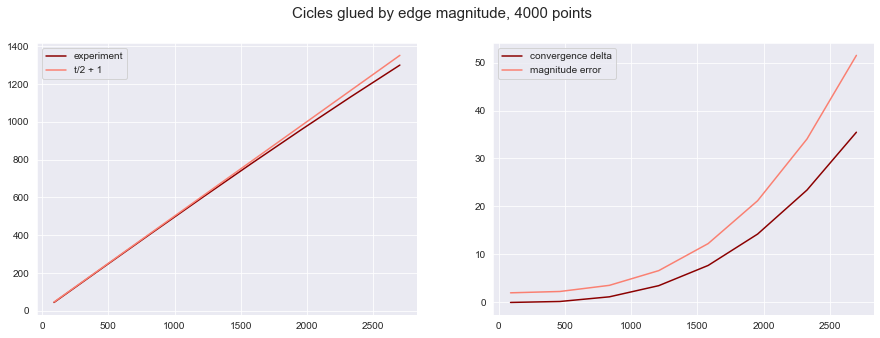

In [4]:
rhombus = MetricGraph(edges=[(0, 1, 1), (0, 2, 4), (1, 2, 1), (0, 3, 1), (2, 3, 2)], vertex_count=4)
magnitude_measures_rhombus = rhombus.approximate_magnitude_function(t_vec, [10, 4000, 5])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Cicles glued by edge magnitude, 4000 points', fontsize=15)
rhombus.plot_all(t_vec, magnitude_measures_rhombus, lambda t: t/2 + 1, 't/2 + 1', (ax1, ax2))

Absolute delta: [1.009975118805805, 1.2901337616652313, 2.5651798909613603, 5.6360357818171, 11.270936804846883, 20.192292837619675, 33.06572843468007, 50.49151252195179]


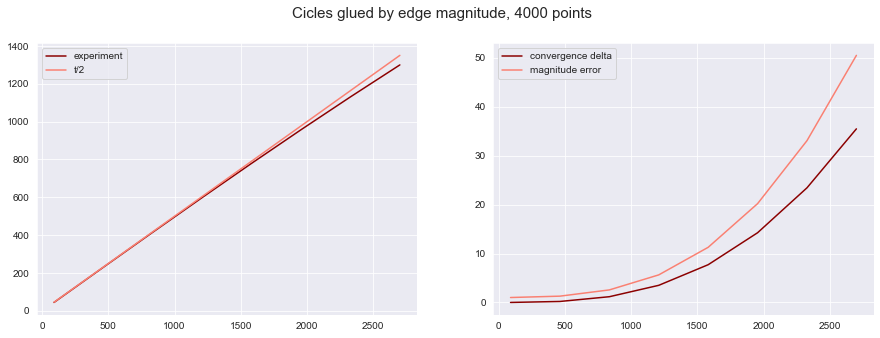

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Cicles glued by edge magnitude, 4000 points', fontsize=15)
rhombus.plot_all(t_vec, magnitude_measures_rhombus, lambda t: t/2, 't/2', (ax1, ax2))

Absolute delta: [0.009975118805805039, 0.2901337616652313, 1.5651798909613603, 4.6360357818171, 10.270936804846883, 19.192292837619675, 32.06572843468007, 49.49151252195179]


Text(0, 0.5, 'Delta')

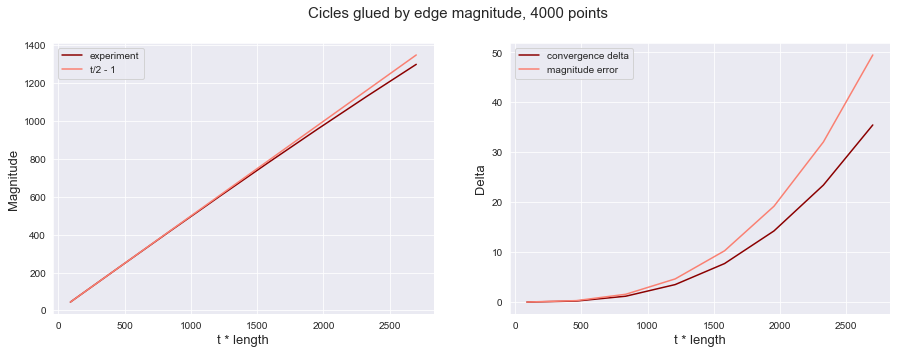

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Cicles glued by edge magnitude, 4000 points', fontsize=15)
rhombus.plot_all(t_vec, magnitude_measures_rhombus, lambda t: t/2 - 1, 't/2 - 1', (ax1, ax2))
ax1.set_xlabel('t * length', fontsize=13)
ax1.set_ylabel('Magnitude', fontsize=13)
ax2.set_xlabel('t * length', fontsize=13)
ax2.set_ylabel('Delta', fontsize=13)

3 ЦИКЛА СКЛЕЕННЫЕ ПО ВЕРШИНЕ

Absolute delta: [3.0323021758468442, 3.5090160555740795, 5.337201030164863, 9.599467399559558, 17.323744315116528, 29.466182743969966, 46.894319965604836, 70.37393927992957]


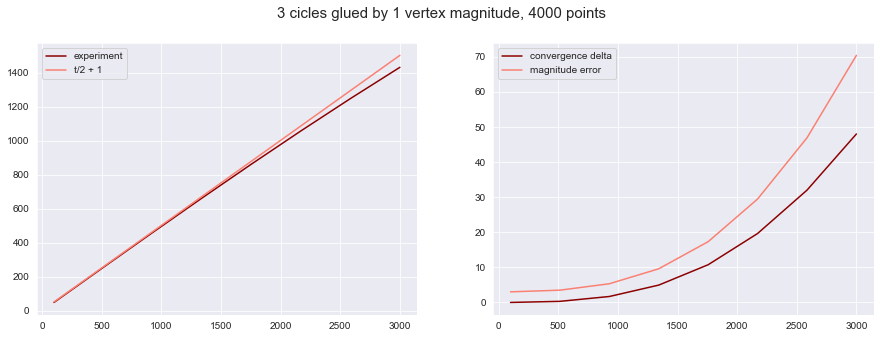

In [24]:
flower = MetricGraph(edges=[(0, 1, 1), (0, 2, 2), (1, 2, 1), (0, 3, 1), (0, 4, 1), (3, 4, 1), (0, 5, 1), (0, 6, 0.5), (5, 6, 1.5)], vertex_count=7)
magnitude_measures_flower = flower.approximate_magnitude_function(t_vec, [10, 4000, 5])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('3 cicles glued by 1 vertex magnitude, 4000 points', fontsize=15)
flower.plot_all(t_vec, magnitude_measures_flower, lambda t: t/2 + 1, 't/2 + 1', (ax1, ax2))

Absolute delta: [2.0323021758468442, 2.5090160555740795, 4.337201030164863, 8.599467399559558, 16.323744315116528, 28.466182743969966, 45.894319965604836, 69.37393927992957]


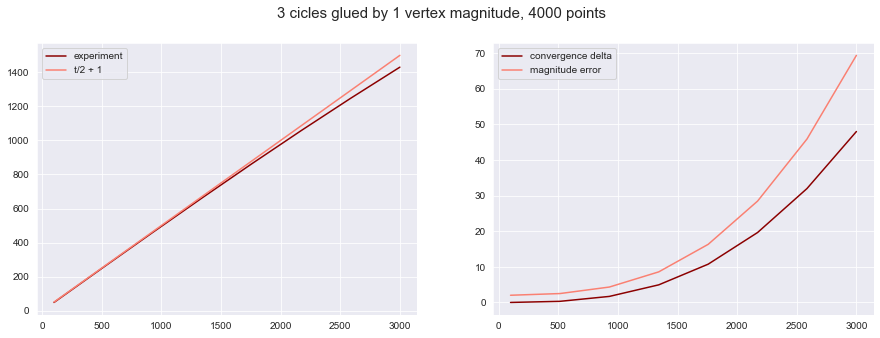

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('3 cicles glued by 1 vertex magnitude, 4000 points', fontsize=15)
flower.plot_all(t_vec, magnitude_measures_flower, lambda t: t/2, 't/2 + 1', (ax1, ax2))

Absolute delta: [1.0323021758468442, 1.5090160555740795, 3.337201030164863, 7.599467399559558, 15.323744315116528, 27.466182743969966, 44.894319965604836, 68.37393927992957]


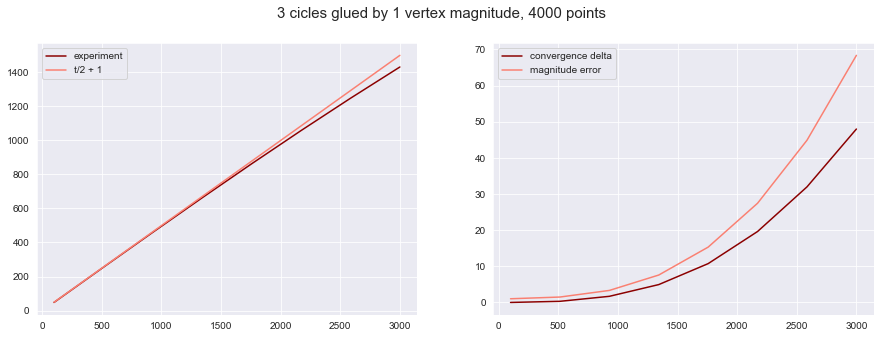

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('3 cicles glued by 1 vertex magnitude, 4000 points', fontsize=15)
flower.plot_all(t_vec, magnitude_measures_flower, lambda t: t/2 - 1, 't/2 + 1', (ax1, ax2))

Absolute delta: [0.03230217584684425, 0.5090160555740795, 2.337201030164863, 6.599467399559558, 14.323744315116528, 26.466182743969966, 43.894319965604836, 67.37393927992957]


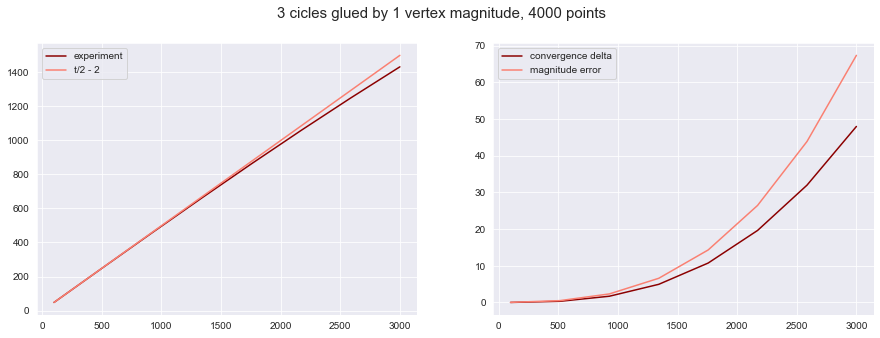

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('3 cicles glued by 1 vertex magnitude, 4000 points', fontsize=15)
flower.plot_all(t_vec, magnitude_measures_flower, lambda t: t/2 - 2, 't/2 - 2', (ax1, ax2))

3 ЦИКЛА СКЛЕЕННЫЕ ПО ОДНОМУ РЕБРУ

Absolute delta: [3.0206224333786835, 3.268953679745323, 4.202819505566481, 6.3818185873054745, 10.348860284149964, 16.623172742401607, 25.693844197226213, 38.014176167894675]


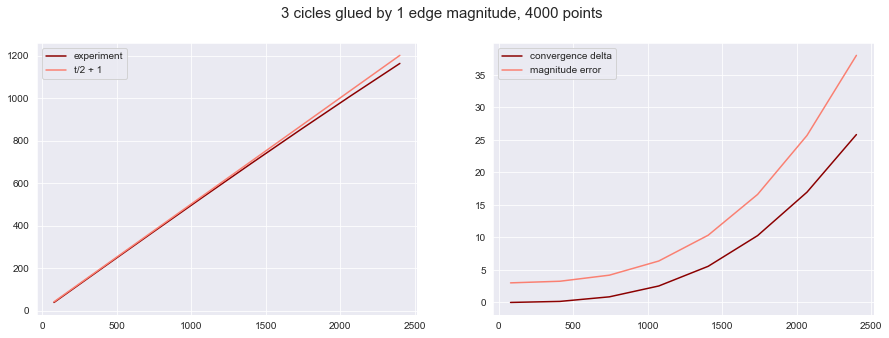

In [28]:
triangles = MetricGraph(edges=[(0, 1, 1), (0, 2, 2), (1, 2, 1), (0, 3, 1), (1, 3, 1), (0, 4, 1), (1, 4, 1)], vertex_count=5)
magnitude_measures_triangles = triangles.approximate_magnitude_function(t_vec, [10, 4000, 5])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('3 cicles glued by 1 edge magnitude, 4000 points', fontsize=15)
triangles.plot_all(t_vec, magnitude_measures_triangles, lambda t: t/2 + 1, 't/2 + 1', (ax1, ax2))

Absolute delta: [2.0206224333786835, 2.268953679745323, 3.202819505566481, 5.3818185873054745, 9.348860284149964, 15.623172742401607, 24.693844197226213, 37.014176167894675]


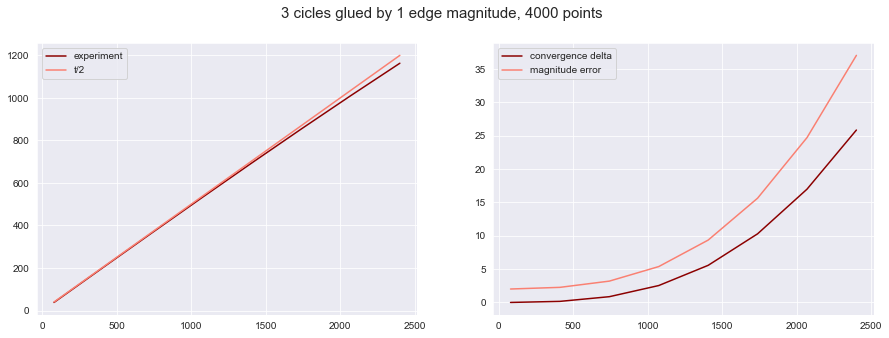

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('3 cicles glued by 1 edge magnitude, 4000 points', fontsize=15)
triangles.plot_all(t_vec, magnitude_measures_triangles, lambda t: t/2, 't/2', (ax1, ax2))

Absolute delta: [1.0206224333786835, 1.268953679745323, 2.202819505566481, 4.3818185873054745, 8.348860284149964, 14.623172742401607, 23.693844197226213, 36.014176167894675]


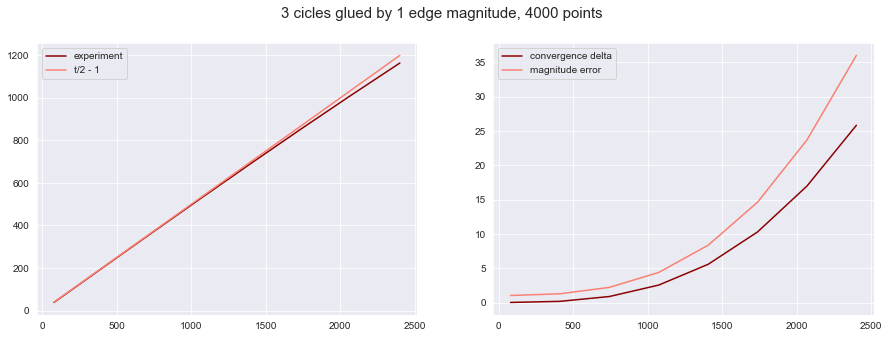

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('3 cicles glued by 1 edge magnitude, 4000 points', fontsize=15)
triangles.plot_all(t_vec, magnitude_measures_triangles, lambda t: t/2 - 1, 't/2 - 1', (ax1, ax2))

Absolute delta: [0.020622433378683525, 0.2689536797453229, 1.202819505566481, 3.3818185873054745, 7.348860284149964, 13.623172742401607, 22.693844197226213, 35.014176167894675]


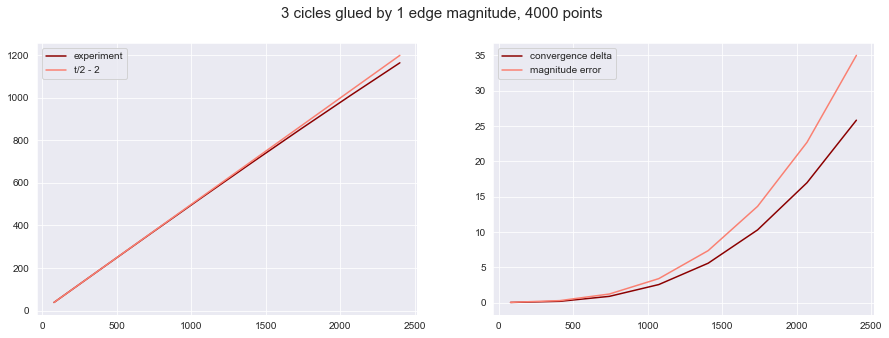

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('3 cicles glued by 1 edge magnitude, 4000 points', fontsize=15)
triangles.plot_all(t_vec, magnitude_measures_triangles, lambda t: t/2 - 2, 't/2 - 2', (ax1, ax2))

3 ЦИКЛА СКЛЕЕННЫЕ ПО РАЗНЫМ РЕБРАМ (1)

Absolute delta: [2.0275385244872552, 2.5643421854590542, 4.895403018547427, 10.469891088554732, 20.650914026060832, 36.680835622671566, 59.65504541341306, 90.50481585130615]


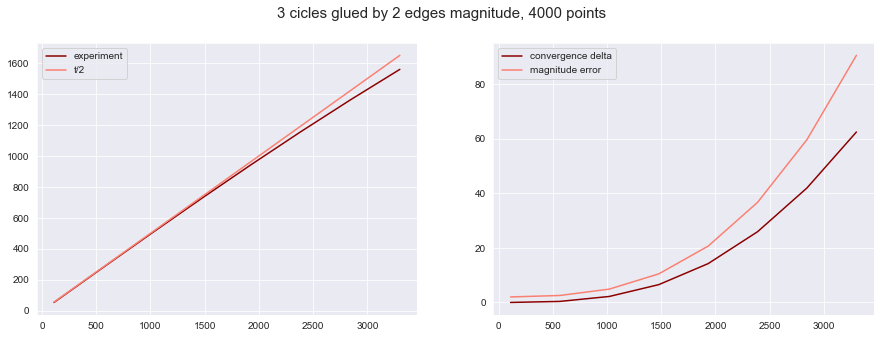

In [32]:
triangles2edges = MetricGraph(edges=[(0, 1, 1), (1, 2, 2), (2, 3, 1), (3, 4, 1), (0, 4, 2), (0, 2, 1), (0, 3, 3)], vertex_count=5)
magnitude_measures_triangles2edges = triangles2edges.approximate_magnitude_function(t_vec, [10, 4000, 5])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('3 cicles glued by 2 edges magnitude, 4000 points', fontsize=15)
triangles2edges.plot_all(t_vec, magnitude_measures_triangles2edges, lambda t: t/2, 't/2', (ax1, ax2))

Absolute delta: [0.027538524487255245, 0.5643421854590542, 2.8954030185474267, 8.469891088554732, 18.650914026060832, 34.680835622671566, 57.65504541341306, 88.50481585130615]


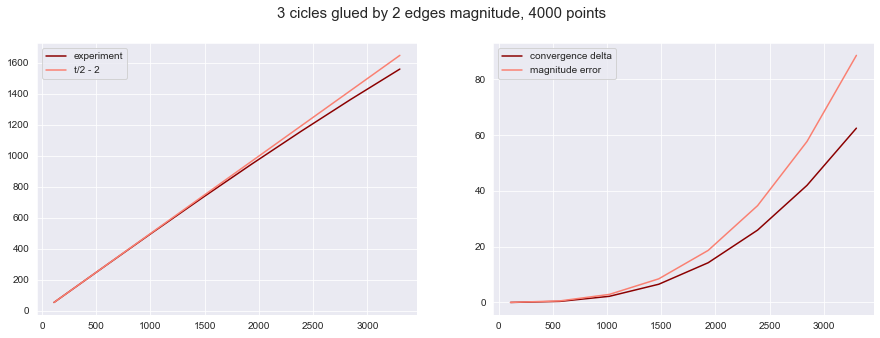

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('3 cicles glued by 2 edges magnitude, 4000 points', fontsize=15)
triangles2edges.plot_all(t_vec, magnitude_measures_triangles2edges, lambda t: t/2 - 2, 't/2 - 2', (ax1, ax2))

3 ЦИКЛА СКЛЕЕННЫЕ ПО РАЗНЫМ РЕБРАМ (2)

Absolute delta: [2.0186993504324775, 2.318185147593084, 3.5842845837334494, 6.619793162801216, 12.198070766426895, 21.048790926965808, 33.84546128716852, 51.19550114006893]


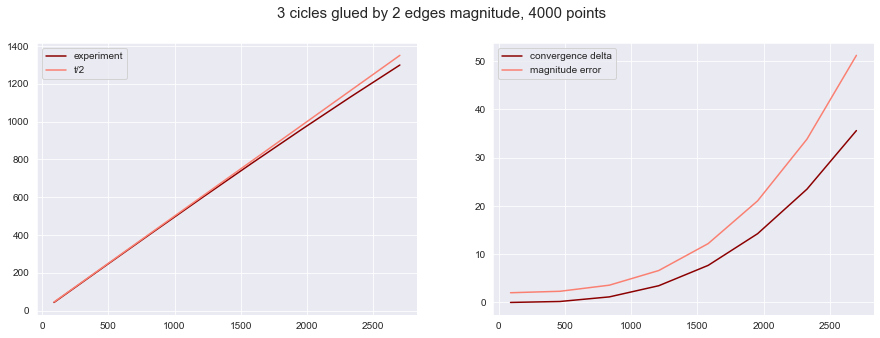

In [34]:
full3 = MetricGraph(edges=[(0, 1, 1), (0, 2, 2), (0, 3, 1), (1, 2, 1), (1, 3, 3), (2, 3, 1)], vertex_count=4)
magnitude_measures_full3 = full3.approximate_magnitude_function(t_vec, [10, 4000, 5])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('3 cicles glued by 2 edges magnitude, 4000 points', fontsize=15)
full3.plot_all(t_vec, magnitude_measures_full3, lambda t: t/2, 't/2', (ax1, ax2))

Absolute delta: [0.0186993504324775, 0.31818514759308414, 1.5842845837334494, 4.619793162801216, 10.198070766426895, 19.048790926965808, 31.84546128716852, 49.19550114006893]


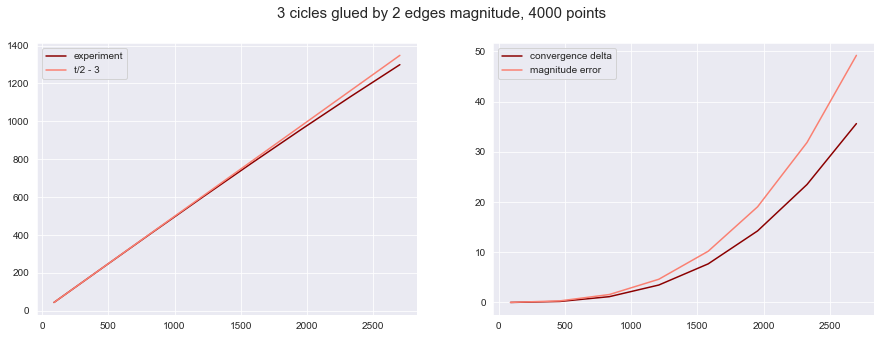

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('3 cicles glued by 2 edges magnitude, 4000 points', fontsize=15)
full3.plot_all(t_vec, magnitude_measures_full3, lambda t: t/2 - 2, 't/2 - 2', (ax1, ax2))